In [195]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import pickle
import mlflow
import requests


# 1.Dataset : Download from sklearn

In [173]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
print(f'Features Shape : {housing.data.shape}')
print(f'Target Shape : {housing.target.shape}')
print(f'Features names: {housing.feature_names}')
print(f'Target name: {housing.target_names}')

Features Shape : (20640, 8)
Target Shape : (20640,)
Features names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target name: ['MedHouseVal']


In [3]:
# features and target are defined (data and column names)
data_features = housing.data
features_names = housing.feature_names
data_target = housing.target

In [4]:
# Función para construir un dataframe
def to_dataframe(data_features,features_names, data_target, target_name='target'):

    dataframe = pd.DataFrame(data=data_features, columns=features_names)
    dataframe[target_name] = data_target
    return dataframe



In [5]:
df_housing= to_dataframe(data_features, features_names, data_target)


# 2. Exploratory Dataset Analysis (EDA)

 California Housing Dataset  

Las características del dataset pueden encontrarse en la documentación oficial de **Scikit-learn**:  
🔗 [California Housing Dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset)  

## 📊 Características del Dataset  
- **Número de instancias**: 20,640  
- **Número de atributos**: 8 (numéricos y predictivos) + 1 objetivo  

## 🏠 Información de los Atributos  
- **MedInc**: Ingreso medio en el grupo de bloques  
- **HouseAge**: Edad media de las viviendas en el grupo de bloques  
- **AveRooms**: Número promedio de habitaciones por hogar  
- **AveBedrms**: Número promedio de dormitorios por hogar  
- **Population**: Población del grupo de bloques  
- **AveOccup**: Número promedio de miembros por hogar  
- **Latitude**: Latitud del grupo de bloques  
- **Longitude**: Longitud del grupo de bloques
- **target**: La variable objetivo es el valor medio de la vivienda en los distritos de California, expresado en cientos de miles de dólares (100.000 $).

Todos las características tienen valores no nulos, por lo que no es necesario realizar tareas de imputacón

In [6]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


## Análisis de las Categorías  

Observando las categorías, podemos destacar lo siguiente:

1. **MedInc**:  
   - Los ingresos medios están escalados en un rango de **0.499900 - 15.000100**.  
   - El histograma presenta **cola hacia la derecha**, lo que sugiere una distribución sesgada.

2. **HouseAge**:  
   - La edad media de las casas más frecuente es de **50 años**.  
   - La media de la edad de las casas es de **28 años**.

3. **AveRooms**:  
   - El número medio de habitaciones por hogar es de **5**.  
   - Se ha detectado un **valor máximo de 141**, que es un **outlier** a tratar más adelante.

4. **AveBedrms**:  
   - El número promedio de dormitorios por hogar es de **1**.  
   - Se ha detectado un **valor máximo de 34**, también un **outlier** a tratar.

5. **Population**:  
   - La distribución de la población presenta **cola hacia la derecha**, indicando valores atípicos.

6. **AveOccup**:  
   - El número de ocupantes presenta **outliers**, que serán tratados más adelante.

7. **Latitude y Longitude**:  
   - Representan la ubicación geográfica de cada distrito.

8. **Target**:  
   - Expresa el valor medio de la casa por distrito en **cientos de miles de dólares**.

In [7]:
df_housing.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Muvhos histogramas están sesgados a la derecha, por lo que probaremos a transformar estos atributos más adelante para tener distribuciones mas simétricas

array([[<Axes: title={'center': 'MedInc'}>,
        <Axes: title={'center': 'HouseAge'}>,
        <Axes: title={'center': 'AveRooms'}>],
       [<Axes: title={'center': 'AveBedrms'}>,
        <Axes: title={'center': 'Population'}>,
        <Axes: title={'center': 'AveOccup'}>],
       [<Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'target'}>]], dtype=object)

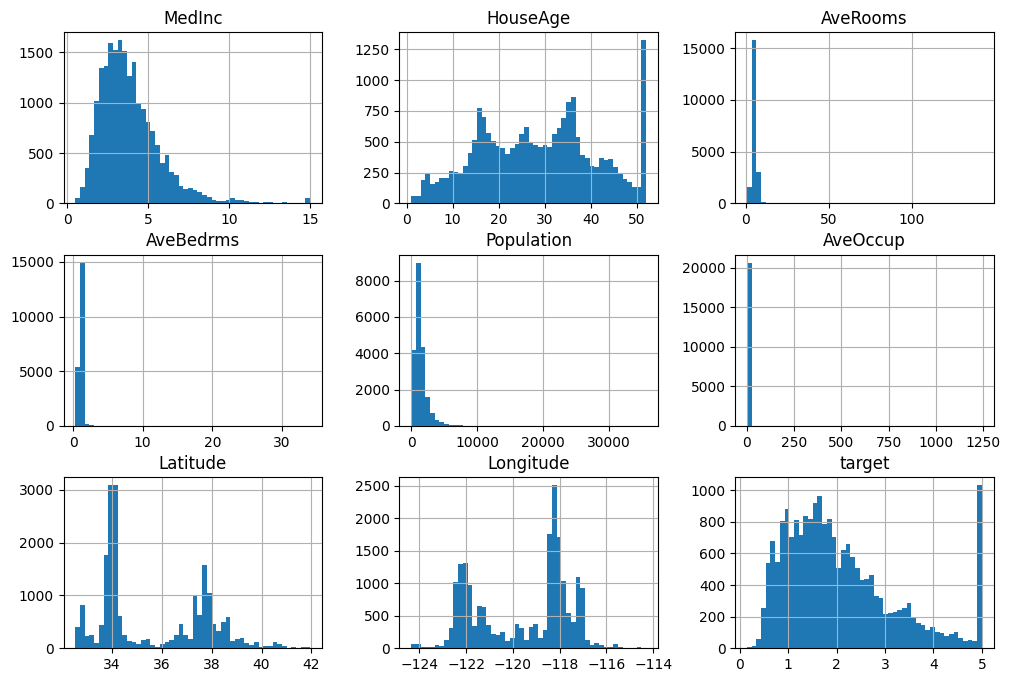

In [8]:
df_housing.hist(bins=50, figsize=(12,8))

Los ingresos medios por distrito parece un atributo importante a la hora de estimar el valor medio de las casas por distrito (target), por lo que vamos a asegurarnos de categorizarlo para después estratificar en la división train/test

In [9]:
df_housing['MedInc_cat']=pd.cut(df_housing['MedInc'],
                            bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                            labels=[1, 2, 3, 4, 5])

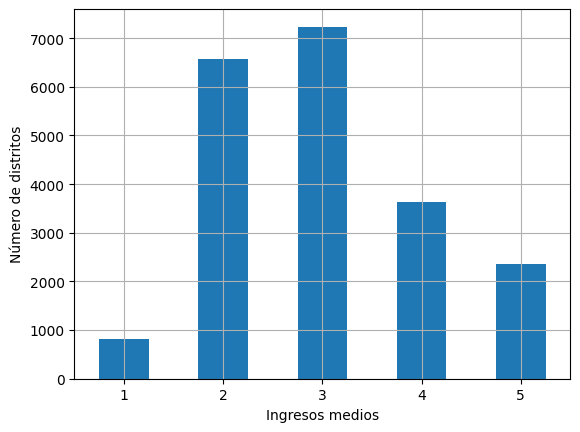

In [10]:
df_housing['MedInc_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Ingresos medios')
plt.ylabel('Número de distritos')
plt.show()

## División train/test

In [11]:
# estratificamos por los ingresos medios por distrito
strat_train_set, strat_test_set = train_test_split(df_housing, test_size=0.2, stratify=df_housing['MedInc_cat'], random_state=42)

In [12]:
print(f'shape de train: {strat_train_set.shape}')
print(f'shape de test: {strat_test_set.shape}')

shape de train: (16512, 10)
shape de test: (4128, 10)


In [13]:
# Eliminamos la variable categórica creada para la estratificación
for c in (strat_train_set, strat_test_set):
    c.drop('MedInc_cat',axis= 1, inplace= True)

#guardamos en csv
strat_train_set.to_csv('full_train',index=False, sep=';')
strat_test_set.to_csv('full_test',index=False, sep=';')

## Correlaciones

In [14]:
# Hacemos una copia de train para trabajar solo con este dataset
train = strat_train_set.copy()

In [15]:
corr_matrix = train.corr()

In [16]:
corr_matrix['target'].sort_values(ascending=False)

target        1.000000
MedInc        0.687151
AveRooms      0.146255
HouseAge      0.114146
AveOccup     -0.021991
Population   -0.026882
AveBedrms    -0.043294
Longitude    -0.047466
Latitude     -0.142673
Name: target, dtype: float64

El gráfico muestra una correlación bastante fuerte, pero debemos tenenr en cuenta las lineas horizontales marcadas, puesto que pueden confundir a nuestro algoritmo a identificar patrones no deseados

<Axes: xlabel='MedInc', ylabel='target'>

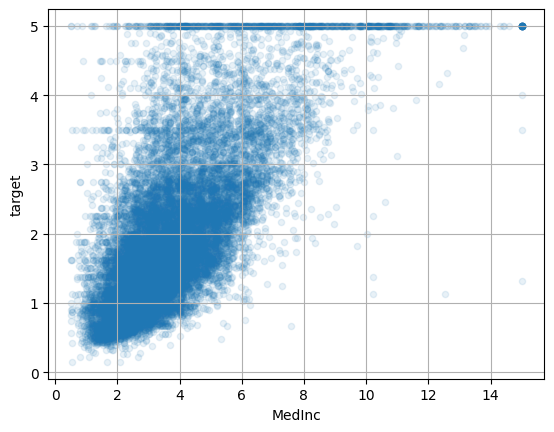

In [17]:
#Creamos un plot con la variable ingresos medios que es la que mas relación tiene
train.plot(kind='scatter', x='MedInc', y='target', alpha=0.1, grid= True)

## Limpieza de datos

In [18]:
def limpieza(train):
    # Eliminación de hogares con mas de 6 dormitorios
    train = train[train['AveBedrms']<6]
    # Elinación de hogares con mas de 10 habitaciones
    train = train[train['AveRooms']<10]
    # Eliminación de hogares con mas de 6 ocupantes
    train = train[train['AveOccup']<6]
    # MedInc y Population están sesgadas, aplicamos logaritmo
    train['MedInc'] = np.log(train['MedInc'])
    train['Population'] = np.log(train['Population'])
    return train

def limpieza(test):
    # Eliminación de hogares con mas de 6 dormitorios
    test = test[test['AveBedrms']<6]
    # Elinación de hogares con mas de 10 habitaciones
    test = test[test['AveRooms']<10]
    # Eliminación de hogares con mas de 6 ocupantes
    test = test[test['AveOccup']<6]
    # MedInc y Population están sesgadas, aplicamos logaritmo
    test['MedInc'] = np.log(test['MedInc'])
    test['Population'] = np.log(test['Population'])
    return test



In [19]:
# Hacemos una copia de train para trabajar solo con este dataset
train = strat_train_set.copy()
test = strat_test_set.copy()

train_cleaned = limpieza(train)
test_cleaned = limpieza(strat_test_set)


In [20]:

train_cleaned.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,16243.000000,16243.000000,16243.000000,16243.000000,16243.000000,16243.000000,16243.000000,16243.000000,16243.000000
mean,1.246713,28.777504,5.279660,1.065699,7.033906,2.907940,35.625317,-119.580268,2.073921
std,0.467529,12.546537,1.228445,0.127714,0.715117,0.719072,2.130041,2.000544,1.156712
min,-0.693347,1.000000,1.130435,0.333333,1.098612,0.750000,32.540000,-124.350000,0.149990
25%,0.943050,18.000000,4.436858,1.005247,6.675823,2.433184,33.930000,-121.810000,1.199500
50%,1.265115,29.000000,5.218504,1.047569,7.064759,2.818493,34.260000,-118.500000,1.804000
75%,1.557913,37.000000,6.022040,1.096491,7.451242,3.276783,37.710000,-118.020000,2.645500
max,2.708057,52.000000,9.979167,3.411111,9.699227,5.995680,41.950000,-114.550000,5.000010


array([[<Axes: title={'center': 'MedInc'}>,
        <Axes: title={'center': 'HouseAge'}>,
        <Axes: title={'center': 'AveRooms'}>],
       [<Axes: title={'center': 'AveBedrms'}>,
        <Axes: title={'center': 'Population'}>,
        <Axes: title={'center': 'AveOccup'}>],
       [<Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'target'}>]], dtype=object)

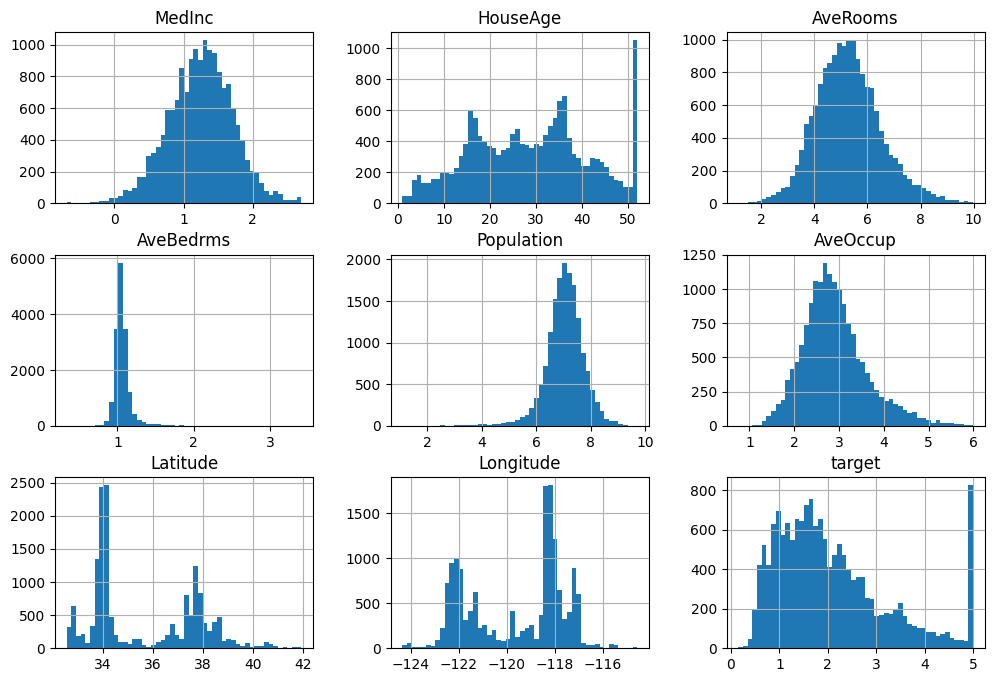

In [21]:
# Comprobamos las transformaciones realizadas plotando los histogramas de nuevo
train_cleaned.hist(bins=50, figsize=(12,8))

## Escalado de características y transformación : Min_max_scaler

En este caso puedo aplicar:
- Normalización: 'Escalado min/max' 
- Estandarización: 'StandardScaler' --> menos sensible a casos atípicos

La idea es utilizar los 2 por separado y logearlo como experimento a MLFlow


In [141]:
#Separamos la variable target
y_train_cleaned = train_cleaned['target']
y_test_cleaned = test_cleaned['target']


# Eliminamos la variable target y lo asignamos a la variable X_train y X_test
X_train_cleaned = train_cleaned.drop('target', axis=1)
X_test_cleaned = test_cleaned.drop('target', axis=1)

print(f'shape X_train: {X_train_cleaned.shape}')
print(f'shape X_test: {X_test_cleaned.shape}')
print(f'shape y_train: {y_train_cleaned.shape}')
print(f'shape y_test: {y_test_cleaned.shape}')

shape X_train: (16243, 8)
shape X_test: (4057, 8)
shape y_train: (16243,)
shape y_test: (4057,)


In [23]:

# Todos los atributos son numéricos, por lo que no es necesario hacer un encoding
# Normalizamos los datos

min_max_scaler = MinMaxScaler(feature_range=(0,1))
X_train_min_max= min_max_scaler.fit_transform(X_train_cleaned)
X_test_min_max= min_max_scaler.transform(X_test_cleaned)

print(f'shape X_train_min_max: {X_train_min_max.shape}')
print(f'shape X_test_min_max: {X_test_min_max.shape}')

shape X_train_min_max: (16243, 8)
shape X_test_min_max: (4057, 8)


In [24]:
X_train_min_max = pd.DataFrame(X_train_min_max, columns=X_train_cleaned.columns)
X_test_min_max = pd.DataFrame(X_test_min_max, columns=X_test_cleaned.columns)

In [25]:
X_train_min_max.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,0.432096,0.549020,0.492206,0.258486,0.769047,0.461057,0.635494,0.294898
1,0.746692,0.117647,0.655082,0.253413,0.756895,0.357189,0.058448,0.726531
2,0.514317,0.843137,0.481752,0.227437,0.628348,0.280866,0.300744,0.541837
3,0.439152,0.450980,0.311422,0.240823,0.662924,0.211453,0.022317,0.736735
4,0.645799,0.509804,0.561224,0.253579,0.746142,0.460806,0.184910,0.576531


## Escalado de características y transformación : StandardScaler

In [26]:
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train_cleaned)
X_test_standard = scaler.transform(X_test_cleaned)

print(f'shape X_train_standard: {X_train_standard.shape}')
print(f'shape X_test_standard: {X_test_standard.shape}')

shape X_train_standard: (16243, 8)
shape X_test_standard: (4057, 8)


In [27]:
X_train_standard = pd.DataFrame(X_train_standard, columns=X_train_cleaned.columns)
X_test_standard = pd.DataFrame(X_test_standard, columns=X_test_cleaned.columns)

In [28]:
print(f'shape X_train_standard: {X_train_standard.shape}')
print(f'shape X_test_standard: {X_test_standard.shape}')
print('-'*len('shape X_test_standard: '))
print(f'shape X_train_min_max: {X_train_min_max.shape}')
print(f'shape X_test_min_max: {X_test_min_max.shape}')
print('-'*len('shape X_test_standard: '))
print(f'shape y_train: {y_train_cleaned.shape}')
print(f'shape y_test: {y_test_cleaned.shape}')


shape X_train_standard: (16243, 8)
shape X_test_standard: (4057, 8)
-----------------------
shape X_train_min_max: (16243, 8)
shape X_test_min_max: (4057, 8)
-----------------------
shape y_train: (16243,)
shape y_test: (4057,)


# 3. Entrenamiento modelo Regresión Lineal

In [68]:
# defino función para guardar modelos.pkl
def save_pkl(df,file_name, path='C:/Users/Pablo/OneDrive/Keepcoding/Práctica Algoritmos/'):
  rute = path + file_name
  with open(rute, 'wb') as f:
    pickle.dump(df, f)

In [128]:
save_pkl(y_train_cleaned, 'y_train_cleaned.pkl')
save_pkl(y_test_cleaned, 'y_test_cleaned.pkl')

## 3.1 MinMax Scaler

In [29]:
lr_model_min_max = LinearRegression()
lr_model_min_max.fit(X_train_min_max, y_train_cleaned)
lr_X_train_min_max_pred = lr_model_min_max.predict(X_train_min_max)
lr_rmse_min_max = (mean_squared_error(y_train_cleaned, lr_X_train_min_max_pred))
lr_rmse_min_max


0.5136578280444176

In [69]:
# Guardamos el modelo
save_pkl(lr_model_min_max, 'lr_model_min_max.pkl')

##  3.2 Standard Scaler

In [30]:
lr_model_standard = LinearRegression()
lr_model_standard.fit(X_train_standard, y_train_cleaned)
std_X_train_pred = lr_model_standard.predict(X_train_standard)
lr_rmse_standard = (mean_squared_error(y_train_cleaned, std_X_train_pred))
lr_rmse_standard

0.5136578280444176

In [70]:
# Guardamos el modelo
save_pkl(lr_model_standard, 'lr_model_standard.pkl')

Vemos que la regresión lineal no es sensible al tipo de escalado para este caso

In [31]:
lr_rmse_min_max == lr_rmse_standard

True

El error cuadratico medio de 0.51 no parece muy satisfactorio, dado que el target se mueve en un rango de 1 a 5. Esto significa que las características no proporcionan suficiente información para hacer buenas predicciones o que el modelo no es lo bastante bueno.
Por otro lado, un coeficiente de determinación de 0,61 indica que el modelo puede explicar el 61% de la variabilidad , lo que sugiere un rendimiento moderado, con ciertta capacidad predictiva, pero con margen de mejora.

In [32]:
print(f' Coeficientes del modelo min_max: {lr_model_min_max.coef_}')
print('-'*100)
print(f' Coeficientes del modelo standard: {lr_model_standard.coef_}')
print('-'*100)
print(f' Intercepto del modelo min_max: {lr_model_min_max.intercept_}')
print('-'*100)
print(f' Intercepto del modelo standard: {lr_model_standard.intercept_}')
print('-'*100)
print(f'Coeficiente de determinación del modelo min_max: {lr_model_min_max.score(X_train_min_max, y_train_cleaned)}')
print('-'*100)
print(f'Coeficiente de determinación del modelo mstandard: {lr_model_standard.score(X_train_standard, y_train_cleaned)}')
print('-'*100)
print(f'Error cuadrático medio del modelo min_max: {lr_rmse_min_max}')
print('-'*100)
print(f'Error cuadrático medio del modelo standard: {lr_rmse_standard}')


 Coeficientes del modelo min_max: [ 4.93030982  0.59566189 -0.07501609  2.06214446  0.21552675 -1.95067258
 -4.52157673 -4.55394588]
----------------------------------------------------------------------------------------------------
 Coeficientes del modelo standard: [ 0.67765834  0.14653458 -0.01041395  0.08556736  0.01791989 -0.2673876
 -1.02346923 -0.92960095]
----------------------------------------------------------------------------------------------------
 Intercepto del modelo min_max: 2.8345488515299664
----------------------------------------------------------------------------------------------------
 Intercepto del modelo standard: 2.0739214861786577
----------------------------------------------------------------------------------------------------
Coeficiente de determinación del modelo min_max: 0.6160719744661292
----------------------------------------------------------------------------------------------------
Coeficiente de determinación del modelo mstandard: 0.61607

Vamos a probar un modelo más complejo, capaz de encontrar relaciones no lineales en los datos

# 4. Entrenamiento modelo: Árbol de decisiones

## 4.1 MinMax Scaler

In [33]:
tree_model_min_max = DecisionTreeRegressor()
tree_model_min_max.fit(X_train_min_max, y_train_cleaned)
tree_X_train_min_max_pred = tree_model_min_max.predict(X_train_min_max)
tree_rmse_min_max = (mean_squared_error(y_train_cleaned, tree_X_train_min_max_pred))
tree_rmse_min_max

9.416987596032395e-32

In [71]:
# Guardamos el modelo
save_pkl(tree_model_min_max, 'tree_model_min_max.pkl')

## 4.2 Standard Scaler

In [34]:
tree_model_standard = DecisionTreeRegressor()
tree_model_standard.fit(X_train_standard, y_train_cleaned)
tree_X_train_standard_pred = tree_model_standard.predict(X_train_standard)
tree_rmse_standard = (mean_squared_error(y_train_cleaned, tree_X_train_standard_pred))
tree_rmse_standard

9.353851526538624e-32

In [72]:
#guardamos el modelo
save_pkl(tree_model_standard, 'tree_model_standard.pkl')

# 5 Validación cruzada

## 5.1 MinMax Scaler

In [35]:
tree_rmse_min_max_cv = -cross_val_score(tree_model_min_max, X_train_min_max, y_train_cleaned, cv=10, scoring='neg_mean_squared_error')
pd.Series(tree_rmse_min_max_cv).describe()


count    10.000000
mean      0.509370
std       0.042715
min       0.420443
25%       0.488531
50%       0.517826
75%       0.538441
max       0.563831
dtype: float64

In [73]:
# Guardamos el modelo
save_pkl(tree_rmse_min_max_cv, 'tree_rmse_min_max_cv.pkl')

## 5.2 Standard Scaler

In [36]:
tree_rmse_standard_cv = -cross_val_score(tree_model_standard, X_train_standard, y_train_cleaned, cv=10, scoring='neg_mean_squared_error')
pd.Series(tree_rmse_standard_cv).describe()

count    10.000000
mean      0.505803
std       0.044941
min       0.394083
25%       0.490757
50%       0.522988
75%       0.535084
max       0.540195
dtype: float64

In [74]:
# Guardamos el modelo
save_pkl(tree_rmse_standard_cv, 'tree_rmse_standard_cv.pkl')

Parece que el modelo de árbol de decisiones  es un poco mejor que el modelo lineal, pero la diferencia es mínima debido al sobreajuste severo, ya que el error de entrenamiento es bajo (en realidaad 0),  mientras que el error de validación es alto. 

In [37]:
print(f'Error cuadrático medio del modelo min_max: {tree_rmse_min_max}')
print('-'*100)
print(f'Error cuadrático medio del modelo standard: {tree_rmse_standard}')
print('-'*100)
print(f'Error cuadrático medio del modelo min_max con validación cruzada: {tree_rmse_min_max_cv.mean()}')
print('-'*100)
print(f'Error cuadrático medio del modelo standard con validación cruzada: {tree_rmse_standard_cv.mean()}')
print('-'*100)

Error cuadrático medio del modelo min_max: 9.416987596032395e-32
----------------------------------------------------------------------------------------------------
Error cuadrático medio del modelo standard: 9.353851526538624e-32
----------------------------------------------------------------------------------------------------
Error cuadrático medio del modelo min_max con validación cruzada: 0.5093701872829115
----------------------------------------------------------------------------------------------------
Error cuadrático medio del modelo standard con validación cruzada: 0.5058027255582649
----------------------------------------------------------------------------------------------------


Vamos a probar a probar con RandomForest, llamados "ensamblajes"; son capaces de aumentar el rendiumiento del modelo subyacente(en este caso, árboles de decisiones).
Funcionan entrenando muchos árboles de decisiones en subconjuntos aleatorios de las caracterísiticas y haciendo un promedio de sus predicciones.

# 6. Entrenamiento modelo: RandomForestRegressor

Aplicamos Random Forest con validación cruzada

## 6.1 MinMax Scaler

In [38]:
forest_model_min_max = RandomForestRegressor()
forest_model_min_max.fit(X_train_min_max, y_train_cleaned)
forest_X_train_min_max_pred = forest_model_min_max.predict(X_train_min_max)
forest_rmse_min_max = (mean_squared_error(y_train_cleaned, forest_X_train_min_max_pred))
forest_rmse_min_max




0.03487804409720161

In [39]:
forest_rmse_min_max_cv = -cross_val_score(forest_model_min_max, X_train_min_max, y_train_cleaned, cv=10, scoring='neg_mean_squared_error')
pd.Series(forest_rmse_min_max_cv).describe()


count    10.000000
mean      0.253407
std       0.022851
min       0.217892
25%       0.235911
50%       0.257717
75%       0.272042
max       0.279634
dtype: float64

In [75]:
# Guardamos el modelo
save_pkl(forest_model_min_max, 'forest_model_min_max.pkl')

## 6.2 Standard Scaler

In [40]:
forest_model_standard = RandomForestRegressor()
forest_model_standard.fit(X_train_standard, y_train_cleaned)
forest_X_train_standard_pred = forest_model_standard.predict(X_train_standard)
forest_rmse_standard = (mean_squared_error(y_train_cleaned, forest_X_train_standard_pred))
forest_rmse_standard

0.034910239433732525

In [41]:
forest_rmse_standard_cv = -cross_val_score(forest_model_standard, X_train_standard, y_train_cleaned, cv=10, scoring='neg_mean_squared_error')
pd.Series(forest_rmse_standard_cv).describe()

count    10.000000
mean      0.252374
std       0.023800
min       0.214806
25%       0.233437
50%       0.254447
75%       0.270069
max       0.281420
dtype: float64

In [76]:
# Guardamos el modelo
save_pkl(forest_model_standard, 'forest_model_standard.pkl')

In [42]:
print(f'Error cuadrático medio del modelo Random forest_min_max: {forest_rmse_min_max}')
print('-'*100)
print(f'Error cuadrático medio del modelo Random forest_standard: {forest_rmse_standard}')
print('-'*100)
print(f'Error cuadrático medio del modelo Random forest_min_max con validación cruzada: {forest_rmse_min_max_cv.mean()}')
print('-'*100)
print(f'Error cuadrático medio del modelo Random forest_standard con validación cruzada: {forest_rmse_standard_cv.mean()}')
print('-'*100)

Error cuadrático medio del modelo Random forest_min_max: 0.03487804409720161
----------------------------------------------------------------------------------------------------
Error cuadrático medio del modelo Random forest_standard: 0.034910239433732525
----------------------------------------------------------------------------------------------------
Error cuadrático medio del modelo Random forest_min_max con validación cruzada: 0.25340686085514696
----------------------------------------------------------------------------------------------------
Error cuadrático medio del modelo Random forest_standard con validación cruzada: 0.25237385874809976
----------------------------------------------------------------------------------------------------


# 7. Perfeccionamiento del modelo : ajuste de hiperparámetros

Búsqueda exhaustiva con GridSearchCV

## 7.1 GridSearch: MinMax Scaler
Utilizamos GridSerachCV: Le decimos con qué parámetros queremos experimentar y qué valores probar y mediante validación cruzada evaluará todas las combinaciones posibles de valores de hiperparámetros.

In [43]:
# quieo buscar los mejores hiperparámetros para el modelo de Random Forest
param_grid = {
    'max_features': [2, 4, 6, 8],
}

grid_search_min_max = GridSearchCV(forest_model_min_max, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_min_max.fit(X_train_min_max, y_train_cleaned)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [2, 4, 6, 8]},
             scoring='neg_mean_squared_error')

In [44]:
grid_search_min_max.best_estimator_

RandomForestRegressor(max_features=2)

In [45]:
cv_res_min_max= pd.DataFrame(grid_search_min_max.cv_results_)
cv_res_min_max.sort_values(by='mean_test_score', ascending=False, inplace=True)
cv_res_min_max[['param_max_features', 'mean_test_score', 'std_test_score', 'rank_test_score']].head()


,param_max_features,mean_test_score,std_test_score,rank_test_score
0,2,-0.241545,0.010132,1
1,4,-0.244089,0.010089,2
2,6,-0.250511,0.008559,3
3,8,-0.254528,0.008785,4


In [77]:
# Guardamos el modelo
save_pkl(grid_search_min_max, 'grid_search_min_max.pkl')

## 7.2 GridSearch: Standard Scaler

In [46]:
# quieo buscar los mejores hiperparámetros para el modelo de Random Forest
param_grid = {
    'max_features': [2, 4, 6, 8],
}

grid_search_standard = GridSearchCV(forest_model_standard, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_standard.fit(X_train_standard, y_train_cleaned)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [2, 4, 6, 8]},
             scoring='neg_mean_squared_error')

In [47]:
cv_res_standard= pd.DataFrame(grid_search_standard.cv_results_)
cv_res_standard.sort_values(by='mean_test_score', ascending=False, inplace=True)
cv_res_standard[['param_max_features', 'mean_test_score', 'std_test_score', 'rank_test_score']].head()

,param_max_features,mean_test_score,std_test_score,rank_test_score
0,2,-0.243453,0.009515,1
1,4,-0.243940,0.008036,2
2,6,-0.252367,0.008718,3
3,8,-0.255259,0.007835,4


In [78]:
# Guardamos el modelo
save_pkl(grid_search_standard, 'grid_search_standard.pkl')

# 8. Elección mejor modelo

In [48]:
final_model = grid_search_standard.best_estimator_
final_model

RandomForestRegressor(max_features=2)

In [49]:
features_importance = final_model.feature_importances_.round(2)
features_importance

array([0.35, 0.06, 0.12, 0.04, 0.03, 0.13, 0.14, 0.13])

In [50]:
sorted(zip(features_importance, X_train_standard.columns), reverse=True)

[(np.float64(0.35), 'MedInc'),
 (np.float64(0.14), 'Latitude'),
 (np.float64(0.13), 'Longitude'),
 (np.float64(0.13), 'AveOccup'),
 (np.float64(0.12), 'AveRooms'),
 (np.float64(0.06), 'HouseAge'),
 (np.float64(0.04), 'AveBedrms'),
 (np.float64(0.03), 'Population')]

En este punto podríamos descartar algunas features que no son importantes en nuestro modelo de predicción (Avebedrms, population y houseAge) y volver a entrenar el modelo 

In [79]:
# Guardamos el modelo
save_pkl(final_model, 'final_model.pkl')

# 9. Evaluación con test

In [145]:
final_predictions_standard = final_model.predict(X_test_standard)
final_rmse = mean_squared_error(y_test_cleaned, final_predictions_standard)
print(f'Error cuadrático medio del modelo final: {final_rmse}')

Error cuadrático medio del modelo final: 0.22574637472621198


In [108]:
# Guardamos predicciones
save_pkl(final_predictions_standard, 'final_predictions_standard.pkl')

# 10. Registro de Métricas con Mlflow

Obtenemos la ui ejecutando "mlflow ui" en Anaconda Prompt y nos devuelve: 
http://127.0.0.1:5000

## 10.1 Despliegue modelo y métricas Regreión Lineal

In [ ]:
# Inicializamos el experimento en mlflow con escalado min_max
mlflow.set_experiment('California Housing')
with mlflow.start_run(run_name='Modelo Regresión Lineal Min_Max'):

    # logging de métricas
    mlflow.log_metrics({
        'rmse': lr_rmse_min_max,
        #'coeficientes': lr_model_min_max.coef_,
        'intercepto': lr_model_min_max.intercept_})

    # logging del modelo
    mlflow.sklearn.log_model(lr_model_min_max, 'lr_model_min_max')


# Inicializamos el experimento en mlflow con escalado standard
mlflow.set_experiment('California Housing')
with mlflow.start_run(run_name='Modelo Regresión Lineal Standard'):

    # logging de métricas
    mlflow.log_metrics({
        'rmse': lr_rmse_standard,
        #'coeficientes': lr_model_standard.coef_,
        'intercepto': lr_model_standard.intercept_})

    # logging del modelo
    mlflow.sklearn.log_model(lr_model_standard, 'lr_model_standard')


2025/02/22 22:52:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/22 22:52:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## 10.2 Despliegue modelo y métricas Árbol de decisiones

In [91]:
# Inicializamos el experimento en mlflow con escalado min_max
mlflow.set_experiment('California Housing')
with mlflow.start_run(run_name='Modelo Árbol de Decisión Min_Max'):

    # logging de métricas
    mlflow.log_metrics({
        'rmse': tree_rmse_min_max,
        'rmse_cv': tree_rmse_min_max_cv.mean()})

    # logging del modelo
    mlflow.sklearn.log_model(tree_model_min_max, 'tree_model_min_max')

# Inicializamos el experimento en mlflow con escalado standard
mlflow.set_experiment('California Housing')
with mlflow.start_run(run_name='Modelo Árbol de Decisión Standard'):

    # logging de métricas
    mlflow.log_metrics({
        'rmse': tree_rmse_standard,
        'rmse_cv': tree_rmse_standard_cv.mean()})

    # logging del modelo
    mlflow.sklearn.log_model(tree_model_standard, 'tree_model_standard')

2025/02/22 22:58:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/22 22:58:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## 10.3 Despliegue modelo y métricas Random Forest

In [92]:
# Inicializamos el experimento en mlflow con escalado min_max
mlflow.set_experiment('California Housing')
with mlflow.start_run(run_name='Modelo Random Forest Min_Max'):

    # logging de métricas
    mlflow.log_metrics({
        'rmse': forest_rmse_min_max,
        'rmse_cv': forest_rmse_min_max_cv.mean()})

    # logging del modelo
    mlflow.sklearn.log_model(forest_model_min_max, 'forest_model_min_max')

# Inicializamos el experimento en mlflow con escalado standard
mlflow.set_experiment('California Housing')
with mlflow.start_run(run_name='Modelo Random Forest Standard'):

    # logging de métricas
    mlflow.log_metrics({
        'rmse': forest_rmse_standard,
        'rmse_cv': forest_rmse_standard_cv.mean()})

    # logging del modelo
    mlflow.sklearn.log_model(forest_model_standard, 'forest_model_standard')

2025/02/22 23:00:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/22 23:00:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## 10.4 Despliegue modelo y métricas modelo final

In [95]:
# Initializamos el experimento en mlflow del modelo final
mlflow.set_experiment('California Housing')
with mlflow.start_run(run_name='Modelo Random Forest Final'):

    # logging de métricas
    mlflow.log_metrics({
        'rmse': final_rmse})
    
    # logging de importancia de las variables
    for i in range(len(features_importance)):
        mlflow.log_metric(f'importancia_{X_train_standard.columns[i]}', features_importance[i])

    # logging hiperparámetro max_features
    mlflow.log_param('max_features', final_model.max_features)
    mlflow.log_param('n_estimators', final_model.n_estimators)


    # logging del modelo
    mlflow.sklearn.log_model(final_model, 'final_model')


2025/02/22 23:28:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## 10.5 fotos despliegue mlflow

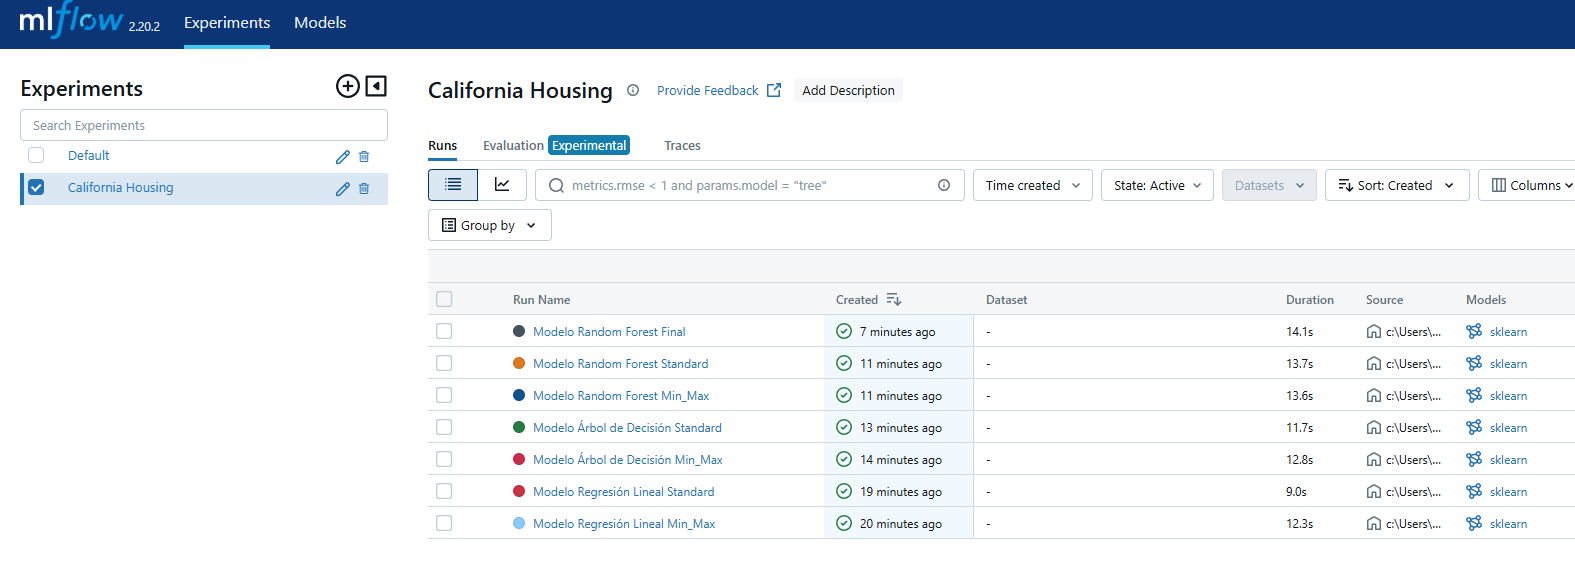

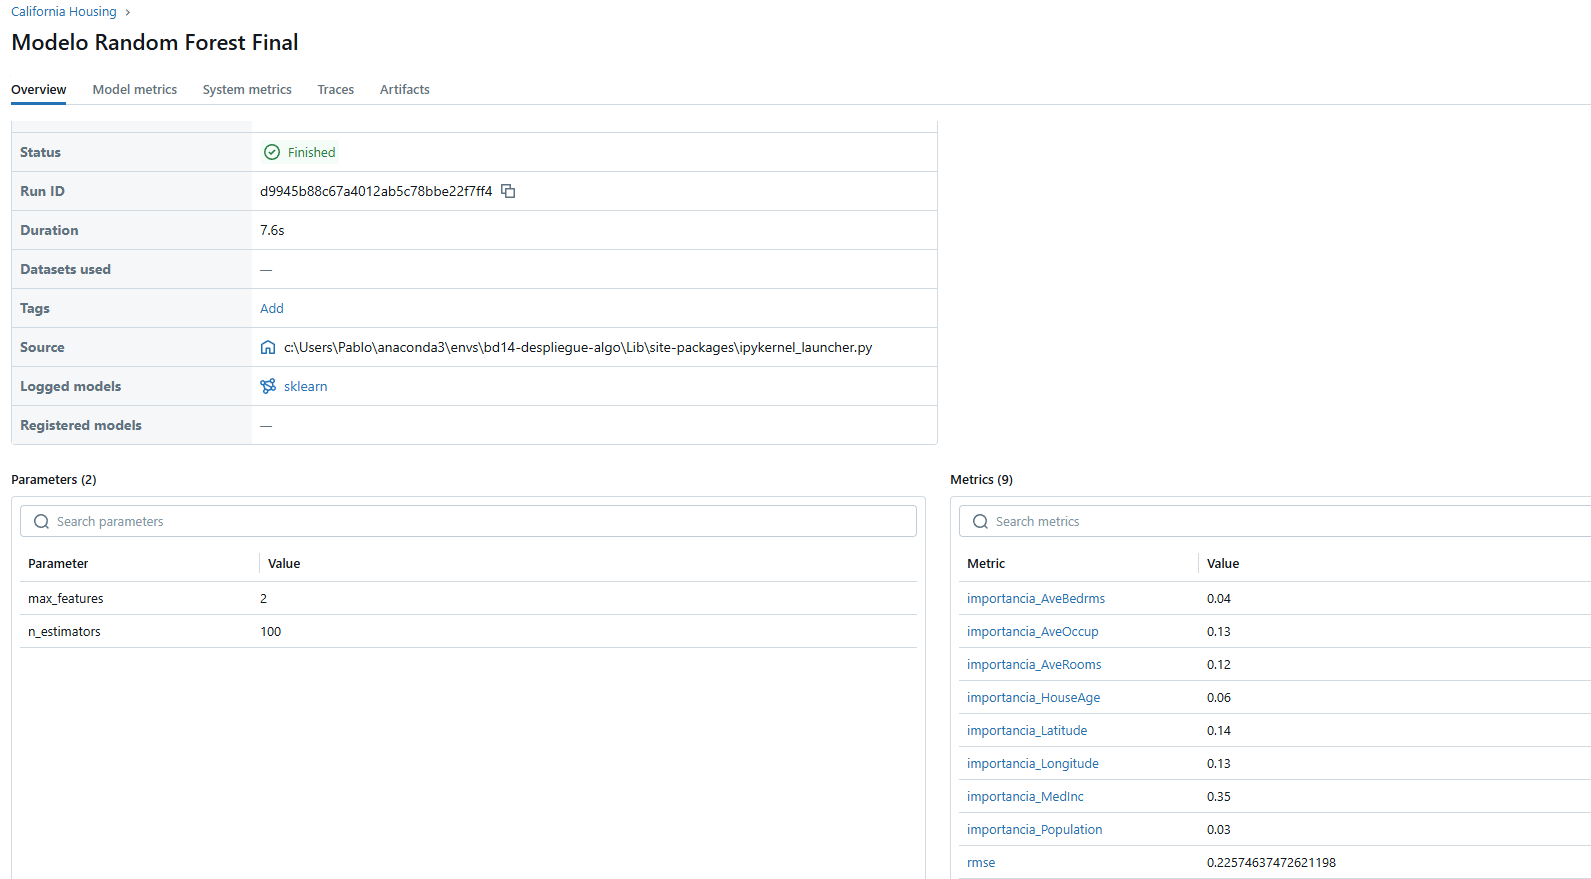

# 11.Generar .py de funciones y main con al menos dos argumentos de entrada.

Voy a crear una función main donde pasaremos 2 argumentos (predicicones y valores reales) para crear un gráfico comparativo

In [153]:
%%writefile print_predict_vs_real.py

def print_predict_vs_real(y_test, final_predictions):
    plt.figure(figsize=(10,6))
    plt.scatter(y_test, final_predictions, alpha=0.1)
    plt.plot([0, 5], [0, 5], 'r-')
    plt.xlabel('Real')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.title('Predicted vs Real')
    plt.legend(['Real', 'Predicted'])
    plt.show()
    
def main():
    print_predict_vs_real(y_test_cleaned, final_predictions_standard)


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Print Predicted vs Real')
    parser.add_argument('--y_test_cleaned', type=str, help='y_test_cleaned')
    parser.add_argument('--final_predictions_standard', type=str, help='final_predictions_standard')
    
    args = parser.parse_args()
    main(args.y_test_cleaned, args.final_predictions_standard)


Overwriting print_predict_vs_real.py


# 12. FastAPI

Ejecutmaos en Anaconda prompt el comando . 'fastapi dev .\main.py' y nos devuelve: http://127.0.0.1:8000/docs

In [192]:
%%writefile main.py
from fastapi import FastAPI
from pydantic import BaseModel
from typing import Optional
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

app = FastAPI()

# Descarga el dataset una vez y conviértelo en DataFrame
housing = fetch_california_housing(as_frame=True)
df_housing = housing.frame

# Cargar el dataset y preparar el modelo
housing = fetch_california_housing(as_frame=True)
df_housing = housing.frame

X = df_housing.drop(columns='MedHouseVal')
y = df_housing['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

final_model = LinearRegression()
final_model.fit(X_train, y_train)


class Identity(BaseModel):
    name: str
    surname: Optional[str] = None

@app.get("/saludo")
def read_root():
    return {"Message": "Hola, estás dentro de la API de mi modelo de Machine Learning"}

@app.post("/test-pydantic/")
def test_pydantic(id: Identity):
    if id.surname is None:
        message = f'Bienvenido a mi Api, {id.name}'
    else:
        message = f'Bienvenido a mi Api, {id.name} {id.surname}'
    return {"message": message}

@app.get("/read_dataset")
def read_dataframe():
    return df_housing.head()

@app.get("/describe_dataset")
def describe_dataframe():
    return df_housing.describe()

# Hacer una predicción cuando el usuario introduzca los datos
@app.post("/predict/")
def predict(data: dict):
    try:
        # Convertir los datos en un DataFrame
        data_df = pd.DataFrame(data, index=[0])

        # Verificar que las columnas coincidan con las usadas en el entrenamiento
        missing_cols = set(X.columns) - set(data_df.columns)
        if missing_cols:
            return {"error": f"Faltan columnas: {missing_cols}"}

        extra_cols = set(data_df.columns) - set(X.columns)
        if extra_cols:
            return {"error": f"Columnas no esperadas: {extra_cols}"}

        # Hacer la predicción
        prediction = final_model.predict(data_df)
        return {"prediction": prediction[0]}
    except Exception as e:
        return {"error": str(e)}

Overwriting main.py


## 12.1 Fotos Fast API

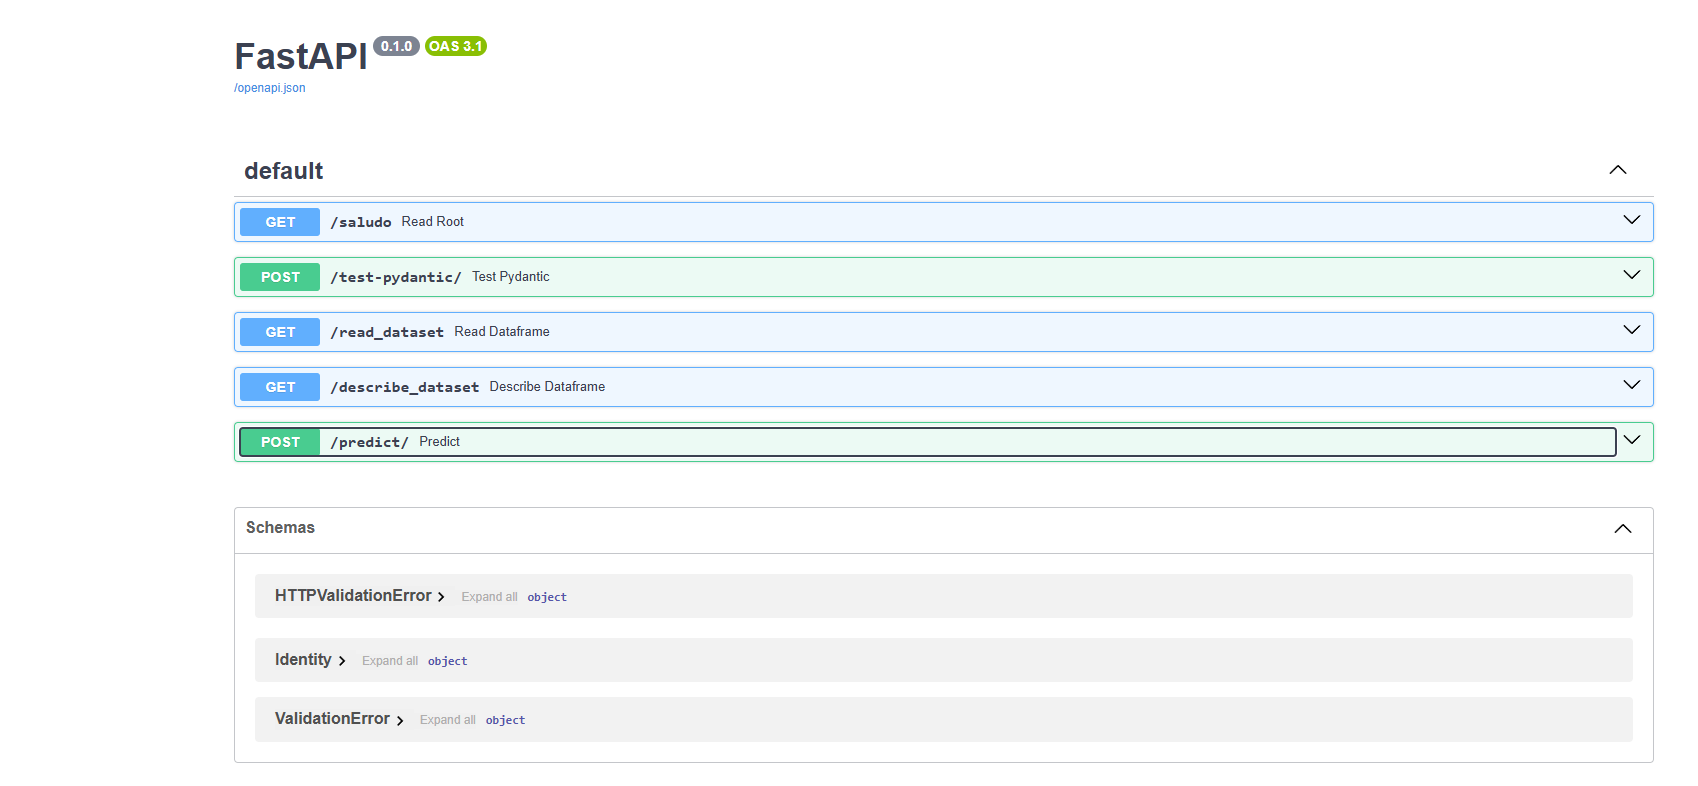

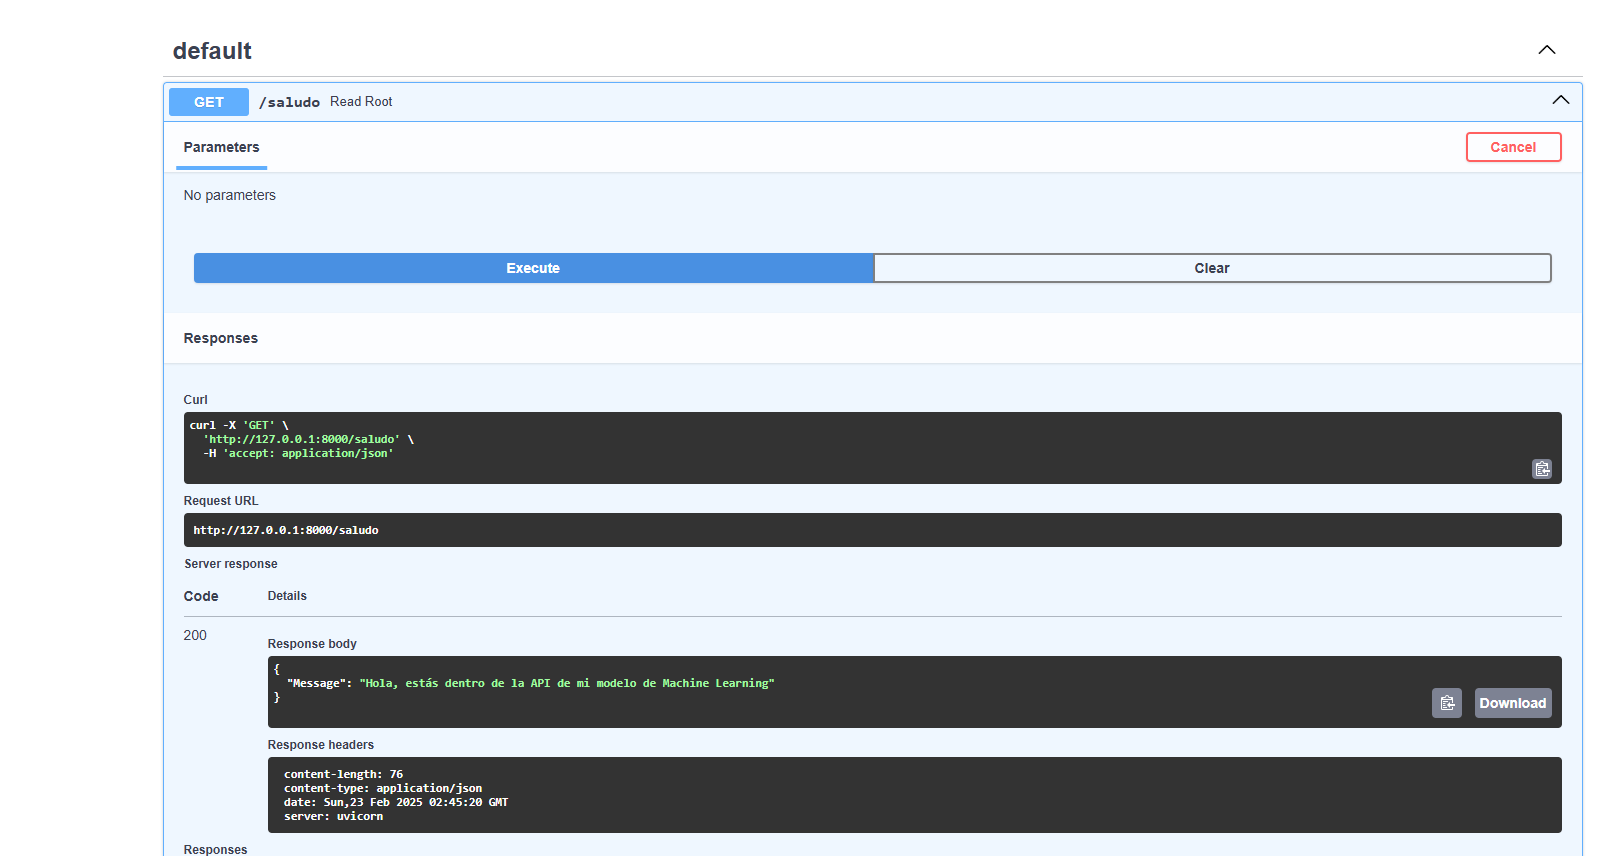

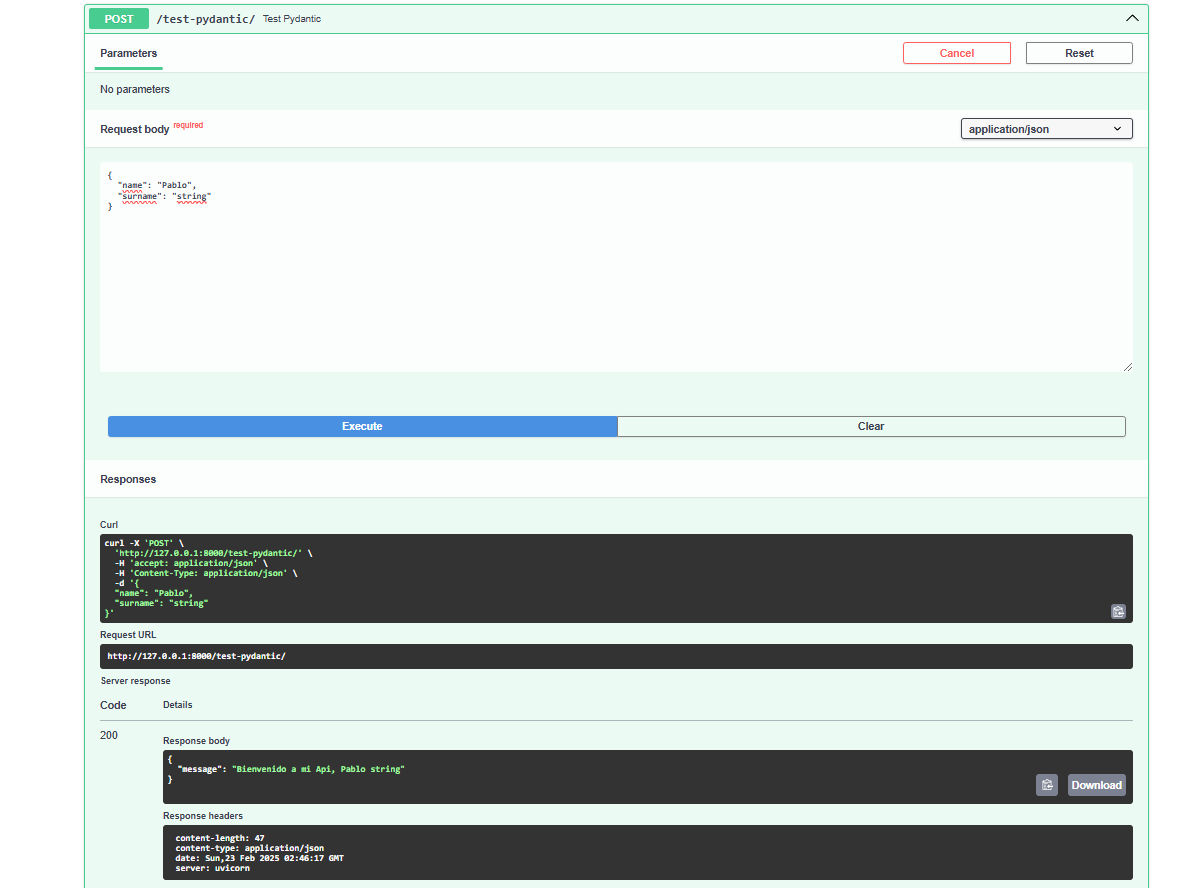

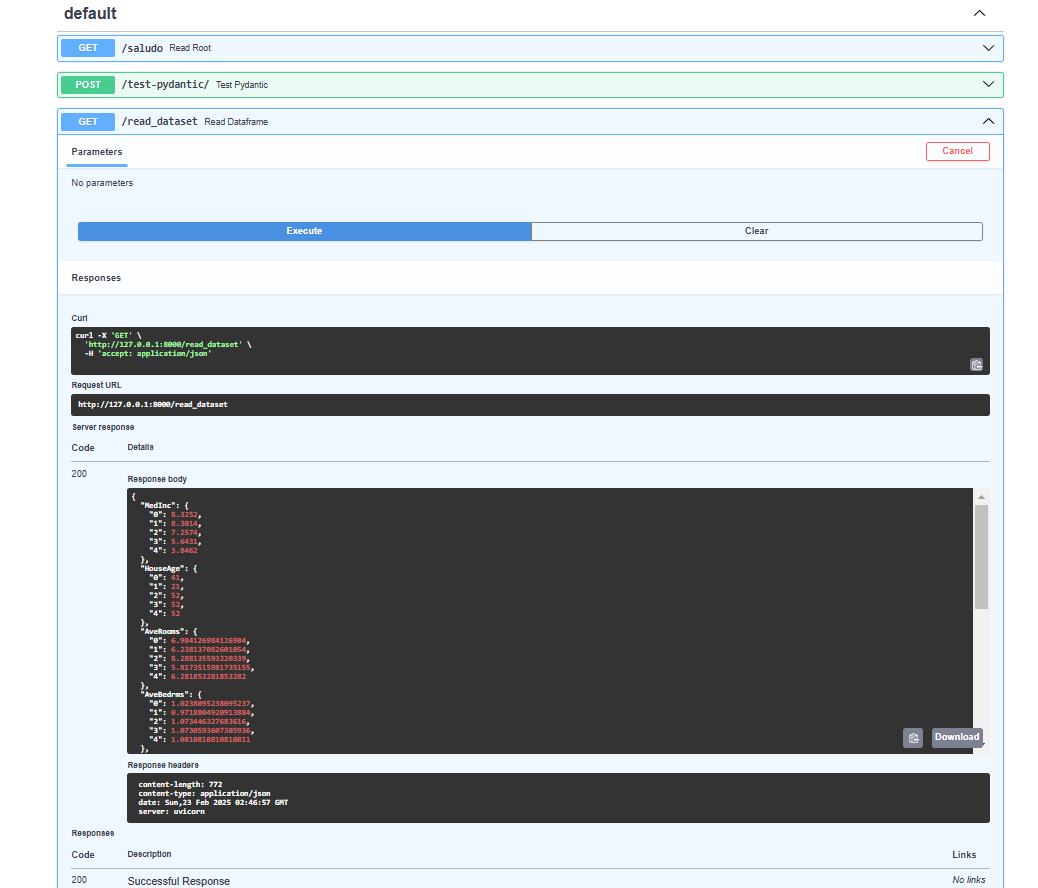

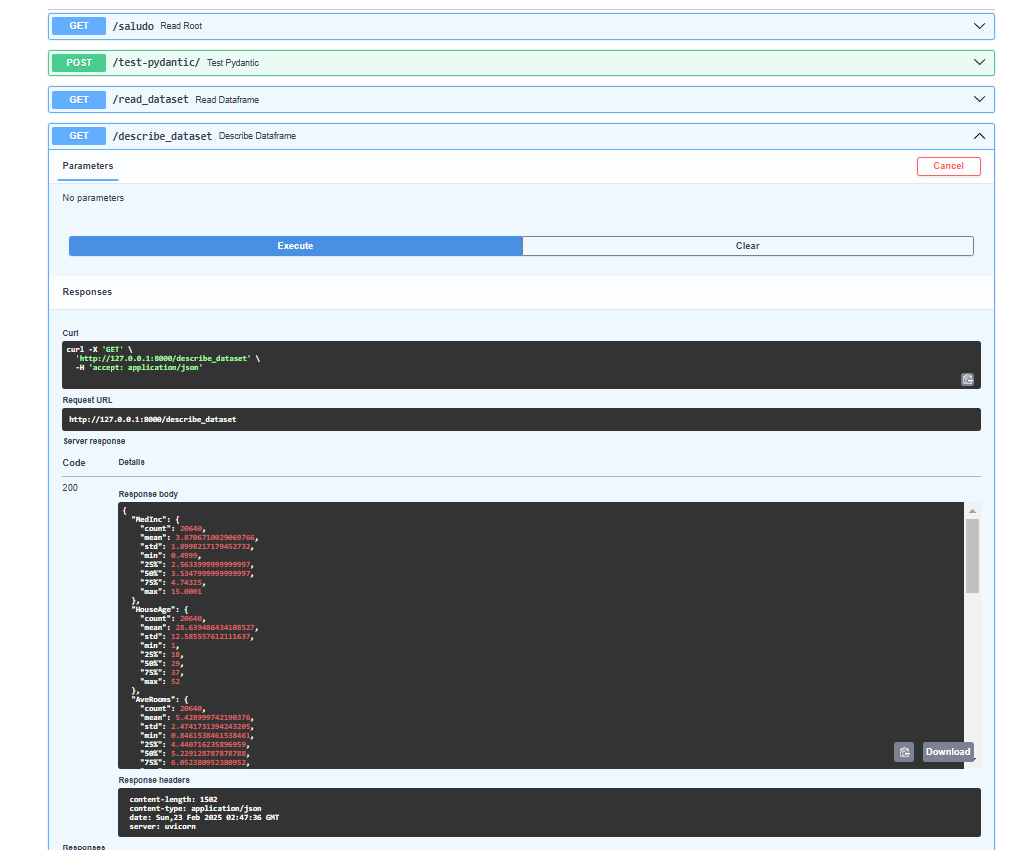

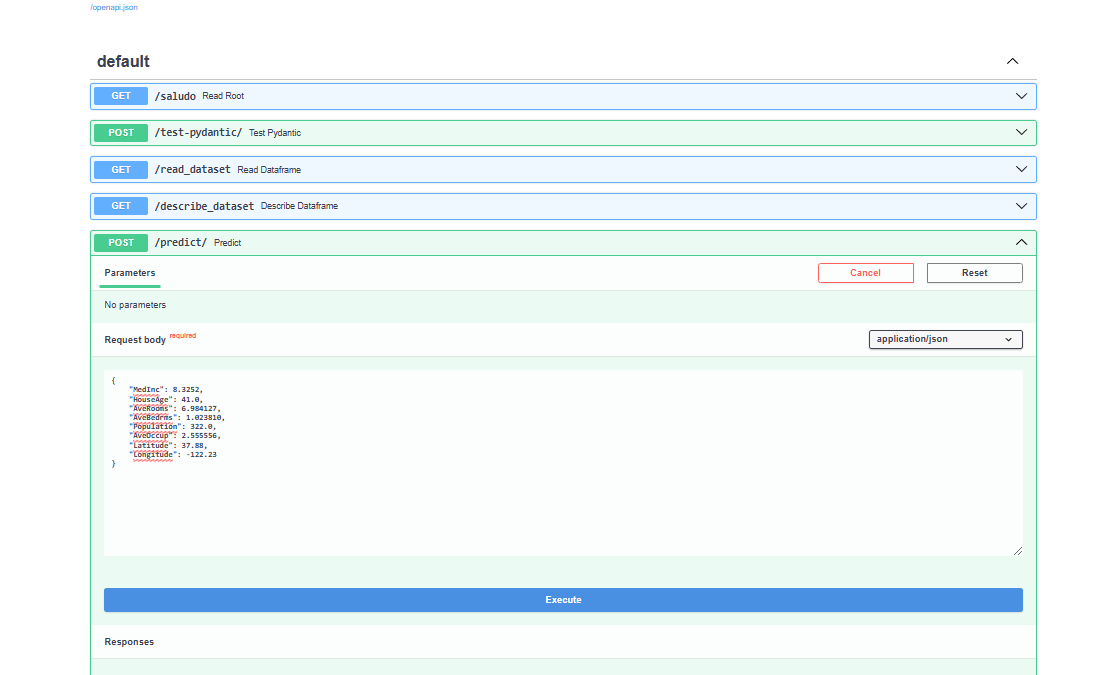

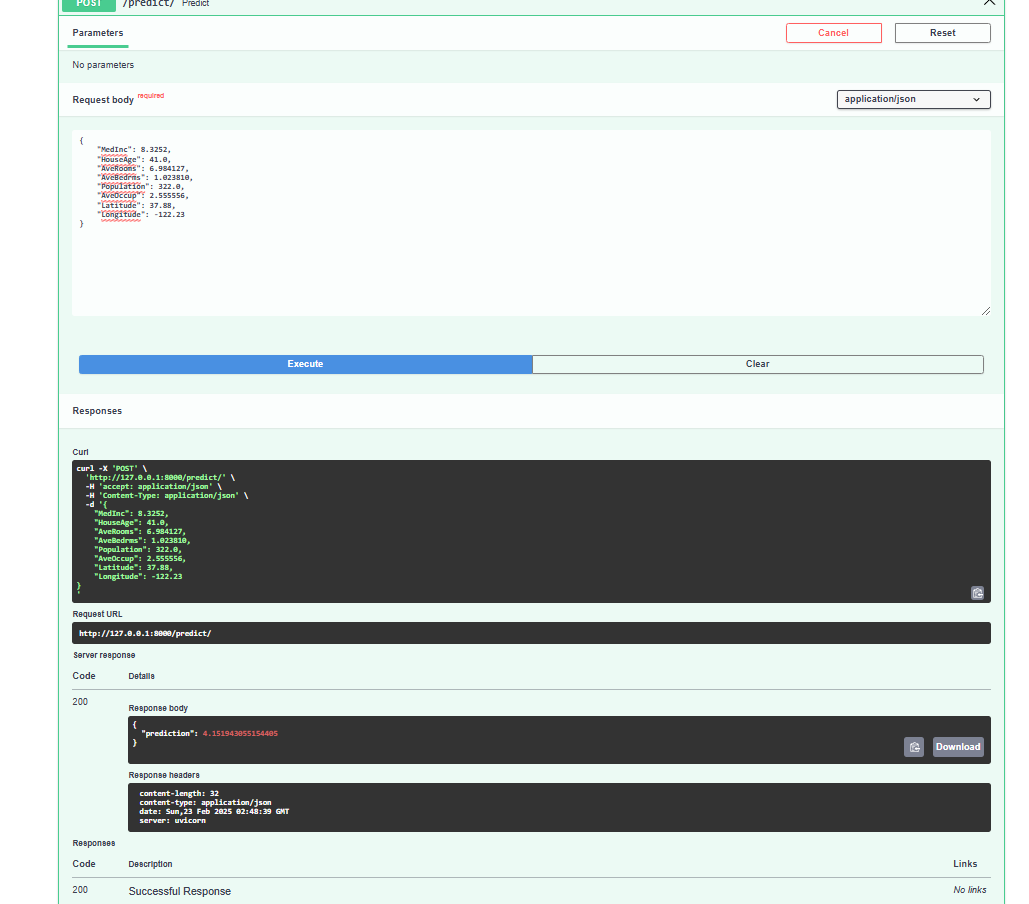

In [196]:
url='http://127.0.0.1:8000/predict/'
response = requests.post(url, json={'MedInc': 8.3252, 'HouseAge': 41.0, 'AveRooms': 6.984126984126984, 'AveBedrms': 1.0238095238095237, 'Population': 322.0, 'AveOccup': 2.5555555555555554, 'Latitude': 37.88, 'Longitude': -122.23})
print(response.json())

{'prediction': 4.151942685753028}
